In [1]:
import numpy as np
import xgboost as xgb
import yaml

from skimage import io
from sklearn.metrics import jaccard_score, f1_score
from skimage import morphology

import matplotlib.pyplot as plt
import PIL

In [2]:
# Increase the limit of allowed images size
PIL.Image.MAX_IMAGE_PIXELS = 10e10

In [3]:
# Set the lame names
lame = "12AG01290_19"
slide = "PANCKm-CD8r"
label = "Stroma"
min_size = 10

In [4]:
# Load the model file
model = xgb.Booster()
model.load_model(f"models/xgboost_{label}.model")

# Set the model to use GPU
model.set_param({'device':'gpu'})

In [5]:
# Load the model parameters
with open(f"models/xgboost_{label}.yaml", "r") as f:
    model_params = yaml.safe_load(f)

threshold = model_params["threshold"]
min_size = model_params["min_size"]

In [6]:
# Cut the image into vertical tiles
img_tiles = np.array_split(ary=io.imread(f'data/{lame}/results/images_aligned/{slide}.ome.tiff'), 
                           indices_or_sections=100,
                           axis=1)

In [7]:
# Apply the model to each image tile
mask_tiles = []
for img_tile in img_tiles:
    # Transform the image into a 2D matrix
    dtest = xgb.DMatrix(img_tile.reshape(-1, 3))

    # Predict the mask
    preds = model.predict(dtest)

    # Append the mask to the mask_tiles list
    mask_tiles.append(preds.reshape(img_tile.shape[:2]) > threshold)

In [8]:
# Concatenate the mask tiles into a single mask
mask = np.concatenate(mask_tiles, axis=1)


In [9]:
# Load the ground truth mask
mask_gt = io.imread(f'data/{lame}/results/masks/{slide}_{label}_mask.png')[:,:mask.shape[1]] > 0

In [10]:
# Compress the mask and ground truth mask
mask_compressed = mask[::100, ::100]
mask_gt_compressed = mask[::100, ::100]

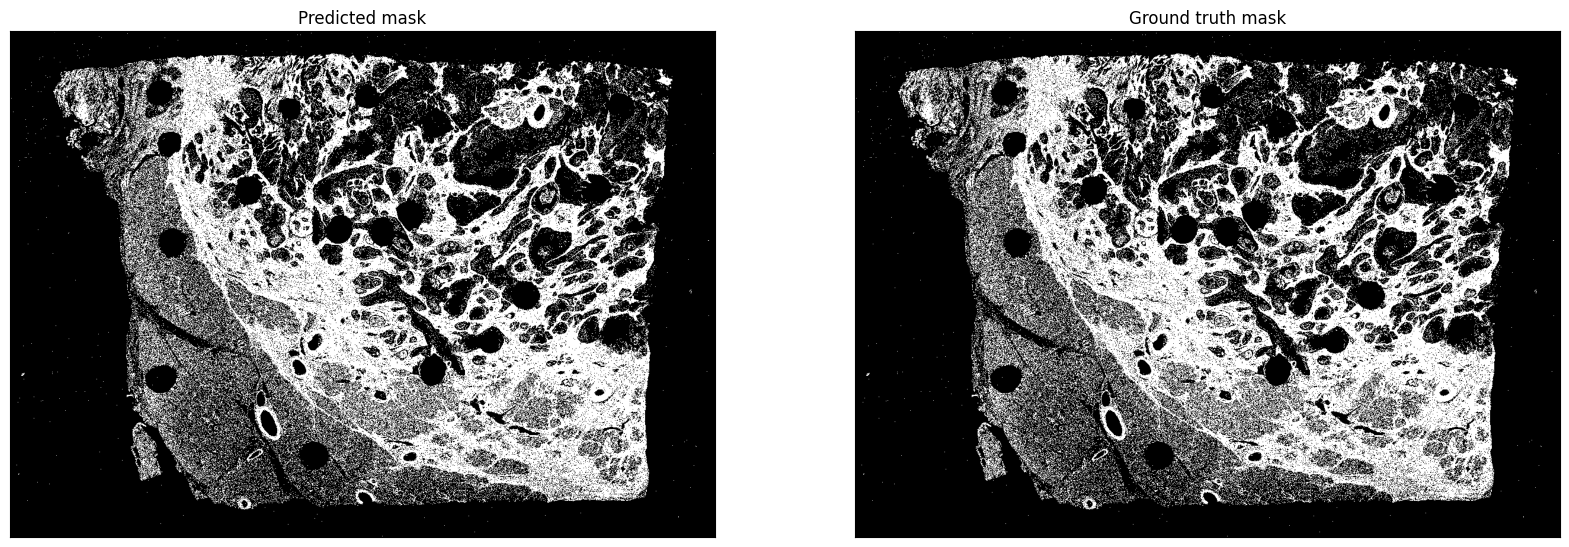

In [11]:
# Plot a compressed version of the mask
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mask_compressed, cmap='gray')
ax[0].set_title('Predicted mask')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mask_gt_compressed, cmap='gray')
ax[1].set_title('Ground truth mask')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

In [18]:
# Comput the intersection over union
iou = jaccard_score(mask_gt_compressed.ravel(), mask_compressed.ravel())

# Compute the F1 score
f1 = f1_score(mask_gt_compressed.ravel(), mask_compressed.ravel())

print(f"IOU of {label} in {slide} = {iou:.2f}")
print(f"F1 of {label} in {slide} = {f1:.2f}")

IOU of Stroma in PANCKm-CD8r = 1.00
F1 of Stroma in PANCKm-CD8r = 1.00


In [15]:
# Clean the mask
mask_clean = morphology.remove_small_objects(mask, min_size=min_size)

# Compress the clean mask
mask_clean_compressed = mask_clean[::100, ::100]

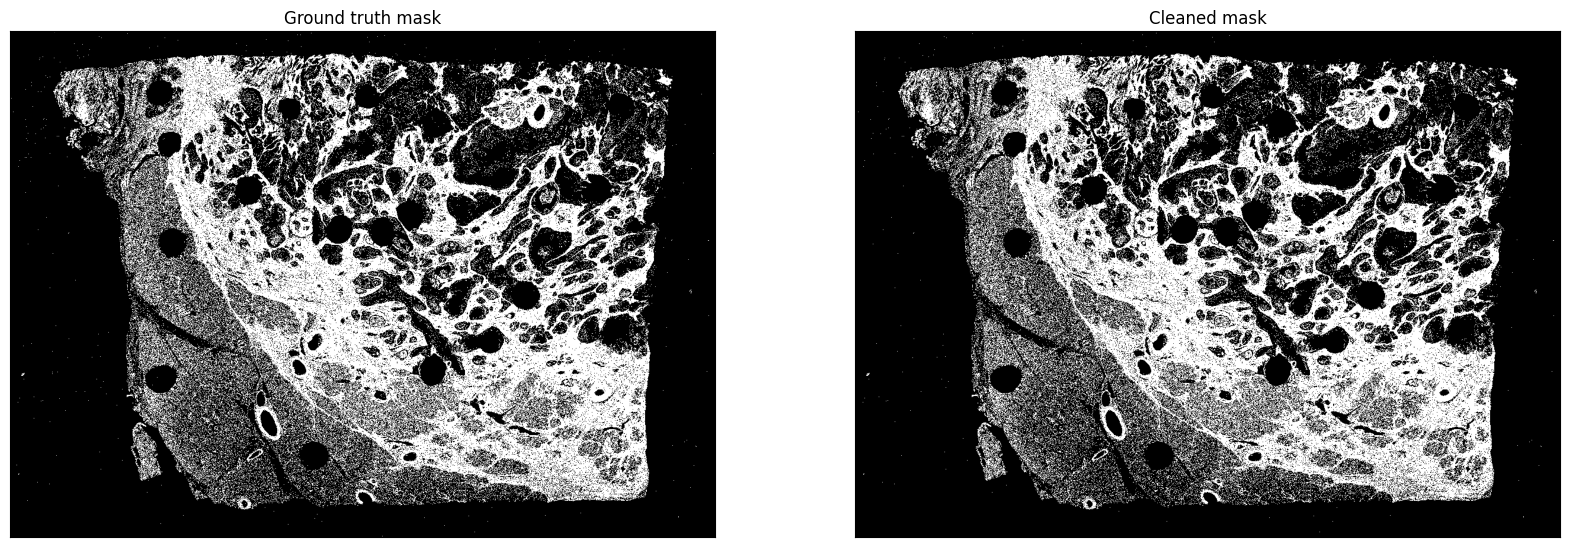

In [17]:
# Plot the cleaned mask
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mask_gt_compressed, cmap='gray')
ax[0].set_title('Ground truth mask')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mask_clean_compressed, cmap='gray')
ax[1].set_title('Cleaned mask')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

In [20]:
# Compute the intersection over union
iou_clean = jaccard_score(mask_gt_compressed.ravel(), mask_clean_compressed.ravel())

# Compute the F1 score
f1_clean = f1_score(mask_gt_compressed.ravel(), mask_clean_compressed.ravel())

print(f"IOU of {label} in {slide} = {iou:.2f}")
print(f"F1 of {label} in {slide} = {f1:.2f}")

IOU of Stroma in PANCKm-CD8r = 1.00
F1 of Stroma in PANCKm-CD8r = 1.00


In [21]:
# Save the mask and the compressed mask
PIL.Image.fromarray(mask_clean).save(f"data/{lame}/results/masks/{slide}_{label}_mask.png")
PIL.Image.fromarray(mask_clean_compressed).save(f"data/{lame}/results/masks/{slide}_{label}_mask_compressed.png")